In [130]:
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

### Information theory and causal inference

Information theory and causal inference play pivotal role in advancing our understanding of complex systems and enabling intelligent decision-making.

**Causal inference** is crucial for extracting meaningful insights from data and making reliable predictions. Causal inference techniques help us move beyond mere correlations and identify the cause-and-effect mechanisms underlying observed data patterns. By uncovering causal relationships, we can make informed predictions, perform counterfactual analyses, and intervene on systems to achieve desired outcomes. Causal inference plays a particularly significant role in domains such as healthcare, economics, and social sciences, where understanding and manipulating causal factors are very important.

**Information theory** provides a framework for quantifying and analyzing the amount of information contained in scientific data, enabling scientists to assess the significance of findings, develop efficient data acquisition strategies, and optimize experimental designs. By applying information theory principles, researchers can uncover patterns, reduce noise, and extract essential features, leading to a deeper understanding of natural processes.

Causal inference, likewise, helps unravel cause-and-effect relationships in complex systems. By employing causal inference techniques, we can identify the factors that drive observed phenomena, validate hypotheses, and design experiments to test causal relationships rigorously. 

Generate synthetic data

In [126]:
np.random.seed(77)
num_samples = 1000 # Define the number of samples

# Generate treated group data
treated_blood_pressure = np.random.normal(110, 5, num_samples)
treated_survival_status = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])  # Lower survival probability
treated_cancer_marker1 = np.random.normal(0.5, 0.1, num_samples)
treated_cancer_marker2 = np.random.normal(3, 0.1, num_samples)
treated_height = np.random.normal(170, 10, num_samples)
treated_weight = np.random.normal(70, 5, num_samples)
treated_age = np.random.normal(50, 10, num_samples)
treated_gender = np.random.choice([0, 1], size=num_samples)  # 0 for Male, 1 for Female
treated_group = ['Treated'] * num_samples

# Generate not treated group data
not_treated_blood_pressure = np.random.normal(120, 8, num_samples)
not_treated_survival_status = np.random.choice([0, 1], size=num_samples, p=[0.4, 0.6])
not_treated_cancer_marker1 = np.random.normal(0.3, 0.1, num_samples)
not_treated_cancer_marker2 = np.random.normal(0.4, 0.1, num_samples)
not_treated_height = np.random.normal(165, 8, num_samples)
not_treated_weight = np.random.normal(65, 5, num_samples)
not_treated_age = np.random.normal(55, 12, num_samples)
not_treated_gender = np.random.choice([0, 1], size=num_samples)  # 0 for Male, 1 for Female
not_treated_group = ['Not Treated'] * num_samples

# Generate survival time for both groups (up to 10 years)
treated_survival_time = np.random.randint(1, 11, num_samples)
not_treated_survival_time = np.random.randint(1, 11, num_samples)

# Combine treated and not treated data
all_blood_pressure = np.concatenate((treated_blood_pressure, not_treated_blood_pressure))
all_survival_status = np.concatenate((treated_survival_status, not_treated_survival_status))
all_cancer_marker1 = np.concatenate((treated_cancer_marker1, not_treated_cancer_marker1))
all_cancer_marker2 = np.concatenate((treated_cancer_marker2, not_treated_cancer_marker2))
all_height = np.concatenate((treated_height, not_treated_height))
all_weight = np.concatenate((treated_weight, not_treated_weight))
all_age = np.concatenate((treated_age, not_treated_age))
all_gender = np.concatenate((treated_gender, not_treated_gender))
all_group = np.concatenate((treated_group, not_treated_group))
all_survival_time = np.concatenate((treated_survival_time, not_treated_survival_time))

# Create a DataFrame with features and target
df = pd.DataFrame({
    'Blood Pressure': all_blood_pressure,
    'Survival Status': all_survival_status,
    'Cancer Marker 1': all_cancer_marker1,
    'Cancer Marker 2': all_cancer_marker2,
    'Height': all_height,
    'Weight': all_weight,
    'Age': all_age,
    'Gender': all_gender,
    'Treatment Group': all_group,
    'Survival Time': all_survival_time
})
df=df.sample(frac=1) # shuffle

df.head(5)


,Blood Pressure,Survival Status,Cancer Marker 1,Cancer Marker 2,Height,Weight,Age,Gender,Treatment Group,Survival Time
1072,114.373080,0,0.154833,0.400625,168.793803,63.580186,56.650208,1,Not Treated,5
1448,130.734375,0,0.439381,0.402845,166.343367,68.194136,38.175561,0,Not Treated,1
1275,113.327824,0,0.406207,0.341166,163.794327,66.849478,71.644492,1,Not Treated,10
641,101.279762,0,0.484449,2.979584,168.311599,77.205775,36.555306,1,Treated,2
1661,119.738394,1,0.178605,0.438978,174.132006,70.592310,51.805217,0,Not Treated,4


In [127]:
df['Survival Status'].value_counts()

0    1173
1     827
Name: Survival Status, dtype: int64

### Causal Inference

**Average Causal Effect:** The average causal effect refers to the difference in the expected outcomes between a treatment group and a control group. It quantifies the average change in the outcome variable that can be attributed to the treatment. It is commonly used in causal inference to assess the effectiveness or impact of a treatment or intervention.

**Causal Odds Ratio:** The causal odds ratio is a measure used to evaluate the effect of a treatment or exposure on the odds of an outcome occurring. It compares the odds of the outcome in the treated group to the odds of the outcome in the control group. The causal odds ratio provides an estimate of the strength and direction of the association between the treatment and the outcome.

**Causal Relative Risk:** The causal relative risk measures the ratio of the risk of an outcome in the treated group to the risk of the outcome in the control group. It provides an estimate of the relative change in the risk of the outcome due to the treatment. The causal relative risk is commonly used in epidemiology and clinical research to assess the impact of interventions on disease risk.

**Association**: Association refers to the statistical relationship or dependence between two variables. It measures the extent to which changes in one variable are related to changes in another variable. An association does not imply causation, but it suggests that there is a connection or pattern between the variables. Association can be measured using various statistical techniques, such as correlation, contingency tables, regression analysis, or hypothesis testing.

In [128]:
def average_causal_effect(df, treatment_col, outcome_col):
    treated_mean = df.loc[df[treatment_col] == 'Treated', outcome_col].mean()
    not_treated_mean = df.loc[df[treatment_col] == 'Not Treated', outcome_col].mean()
    return treated_mean - not_treated_mean

def causal_odds_ratio(df, treatment_col, outcome_col):
    treated_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].sum()
    treated_non_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].count() - treated_outcomes
    not_treated_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].sum()
    not_treated_non_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].count() - not_treated_outcomes
    return (treated_outcomes / treated_non_outcomes) / (not_treated_outcomes / not_treated_non_outcomes)

def causal_relative_risk(df, treatment_col, outcome_col):
    treated_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].sum()
    treated_non_outcomes = df.loc[df[treatment_col] == 'Treated', outcome_col].count() - treated_outcomes
    not_treated_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].sum()
    not_treated_non_outcomes = df.loc[df[treatment_col] == 'Not Treated', outcome_col].count() - not_treated_outcomes
    return (treated_outcomes / (treated_outcomes + treated_non_outcomes)) / (not_treated_outcomes / (not_treated_outcomes + not_treated_non_outcomes))

def association(df, treatment_col, outcome_col):
    treated_mean = df.loc[df[treatment_col] == 'Treated', outcome_col].mean()
    not_treated_mean = df.loc[df[treatment_col] == 'Not Treated', outcome_col].mean()
    return treated_mean - not_treated_mean

In [123]:
# Calculate the average causal effect
ace = average_causal_effect(df, 'Treatment Group', 'Survival Status')
print('Average Causal Effect:', ace)

# Calculate the causal odds ratio
cor = causal_odds_ratio(df, 'Treatment Group', 'Survival Status')
print('Causal Odds Ratio:', cor)

# Calculate the causal relative risk
crr = causal_relative_risk(df, 'Treatment Group', 'Survival Status')
print('Causal Relative Risk:', crr)

# Calculate the association between two variables
assos = association(df, 'Treatment Group', 'Survival Status')
print("Association (α):", assos)

Average Causal Effect: -0.372
Causal Odds Ratio: 0.19405681899426092
Causal Relative Risk: 0.37055837563451777
Association (α): -0.372


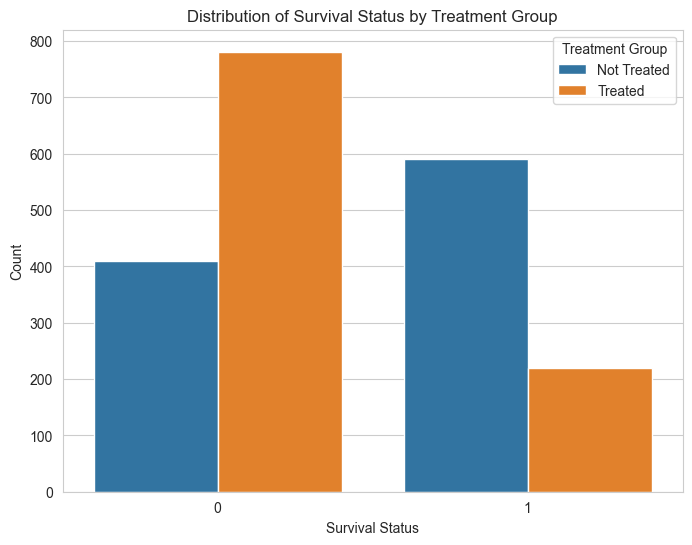

In [118]:
# Create a bar plot of Survival Status by Treatment Group
plt.figure(figsize=(8, 6))
sns.countplot(x='Survival Status', hue='Treatment Group', data=df)
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Distribution of Survival Status by Treatment Group')
plt.legend(title='Treatment Group')
plt.show()

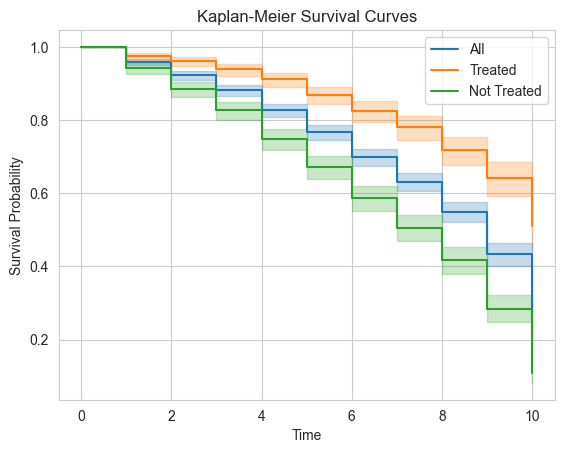

In [119]:
# Fit Kaplan-Meier curves for each treatment group
kmf = KaplanMeierFitter()
kmf.fit(df['Survival Time'], event_observed=df['Survival Status'], label='All')
kmf.plot()

kmf.fit(df.loc[df['Treatment Group'] == 'Treated', 'Survival Time'], event_observed=df.loc[df['Treatment Group'] == 'Treated', 'Survival Status'], label='Treated')
kmf.plot()

kmf.fit(df.loc[df['Treatment Group'] == 'Not Treated', 'Survival Time'], event_observed=df.loc[df['Treatment Group'] == 'Not Treated', 'Survival Status'], label='Not Treated')
kmf.plot()

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves')
plt.legend()
plt.show()